In [83]:
from os import listdir
from matplotlib import image

#list of 10,000 images as numpy arrays; 128x128 pixels, 3 colour channels

loaded_images = list()

count = 0

for filename in listdir(r"C:\Users\david\Downloads\Celeb_pics\100k\100k"):
    
    img_data = image.imread(r"C:\Users\david\Downloads\Celeb_pics\100k\100k/" + filename)
    loaded_images.append(img_data)
    print('> loaded %s %s' % (filename, img_data.shape))
    
    count += 1
    
    if count == 5000:
        break
            

> loaded 000001.jpg (128, 128, 3)
> loaded 000002.jpg (128, 128, 3)
> loaded 000003.jpg (128, 128, 3)
> loaded 000006.jpg (128, 128, 3)
> loaded 000008.jpg (128, 128, 3)
> loaded 000009.jpg (128, 128, 3)
> loaded 000016.jpg (128, 128, 3)
> loaded 000017.jpg (128, 128, 3)
> loaded 000020.jpg (128, 128, 3)
> loaded 000021.jpg (128, 128, 3)
> loaded 000022.jpg (128, 128, 3)
> loaded 000024.jpg (128, 128, 3)
> loaded 000026.jpg (128, 128, 3)
> loaded 000028.jpg (128, 128, 3)
> loaded 000030.jpg (128, 128, 3)
> loaded 000033.jpg (128, 128, 3)
> loaded 000035.jpg (128, 128, 3)
> loaded 000036.jpg (128, 128, 3)
> loaded 000037.jpg (128, 128, 3)
> loaded 000039.jpg (128, 128, 3)
> loaded 000041.jpg (128, 128, 3)
> loaded 000042.jpg (128, 128, 3)
> loaded 000044.jpg (128, 128, 3)
> loaded 000046.jpg (128, 128, 3)
> loaded 000047.jpg (128, 128, 3)
> loaded 000050.jpg (128, 128, 3)
> loaded 000055.jpg (128, 128, 3)
> loaded 000056.jpg (128, 128, 3)
> loaded 000057.jpg (128, 128, 3)
> loaded 00006

In [84]:
#set test, train and batch sizes
train_size = 4000
test_size = 1000
batch_size = 32

In [85]:
import numpy as np
import tensorflow as tf

X = np.stack(loaded_images, axis=0)
X = X.astype('float32')

#rescale images from [0,255] to [0,1]

Z = X / 255

#test-train split

train_images = Z[:train_size]
test_images = Z[train_size:]


train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [86]:
class VAE(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2,2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2,2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32*32*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
            
        ])
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
        
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparametrize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
        
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [87]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparametrize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [88]:
epochs = 10
latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

In [89]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparametrize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(8, 8))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,:])
        plt.axis('off')
        
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show

In [90]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate,:,:,:]

Epoch: 10, Test set ELBO: -29578.041015625, time elapse for current epoch: 396.6058247089386


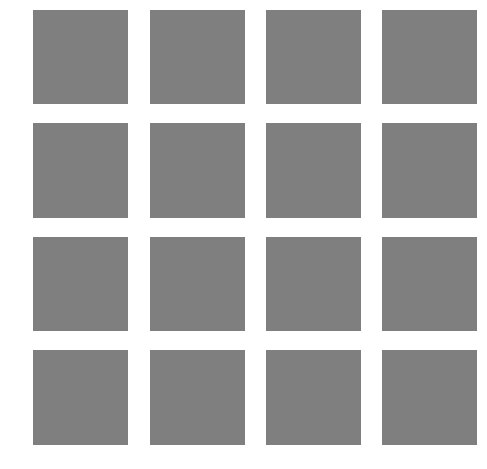

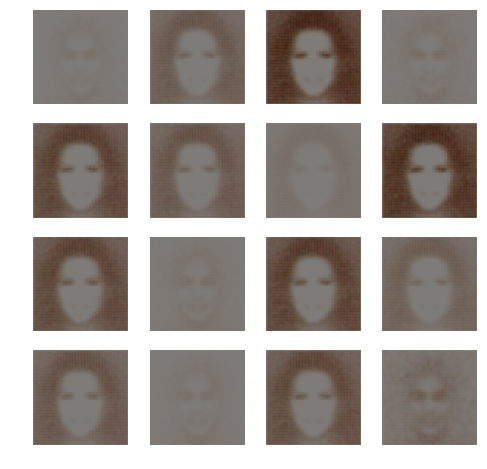

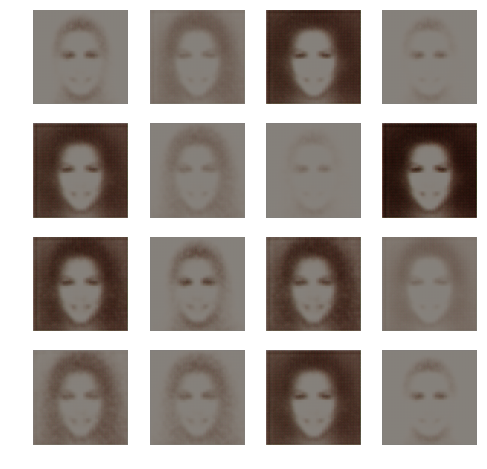

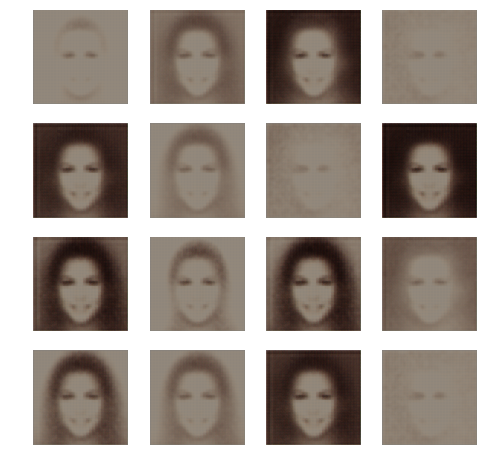

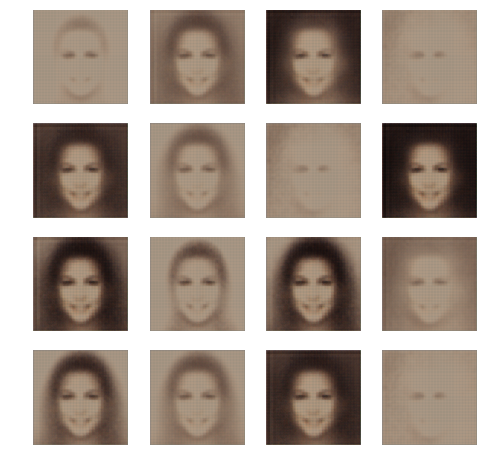

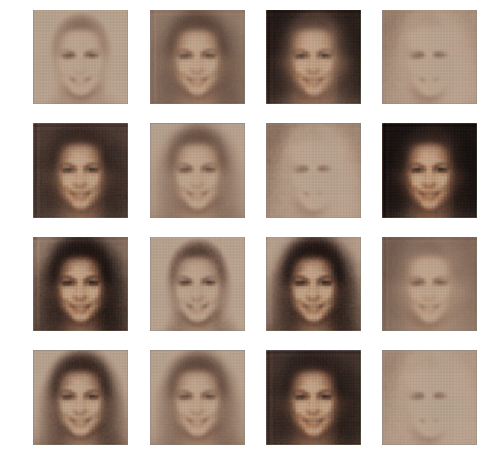

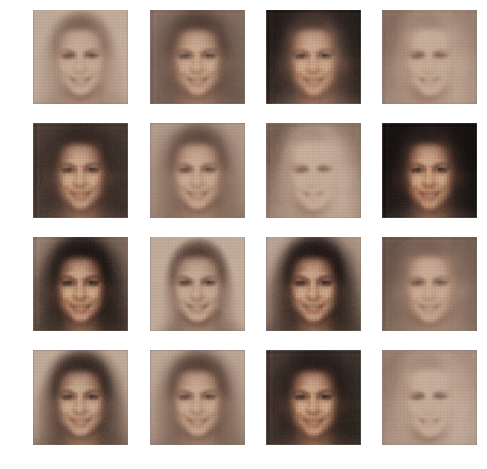

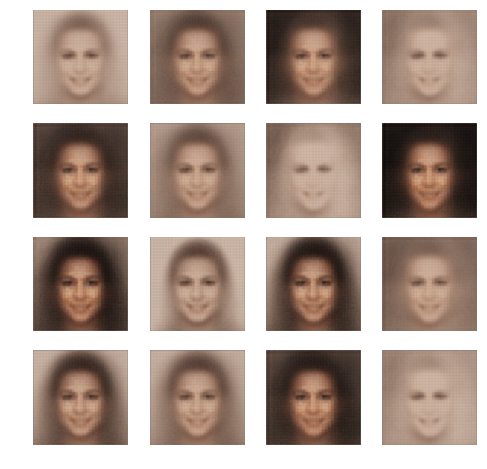

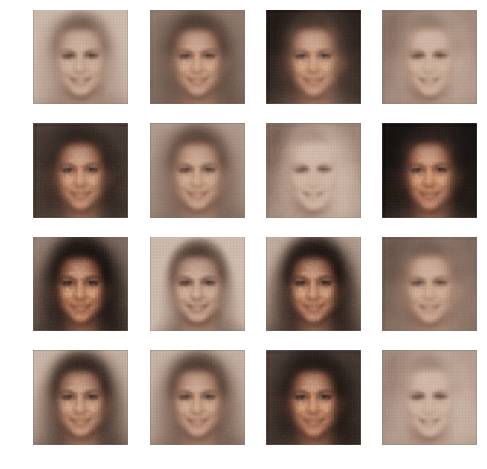

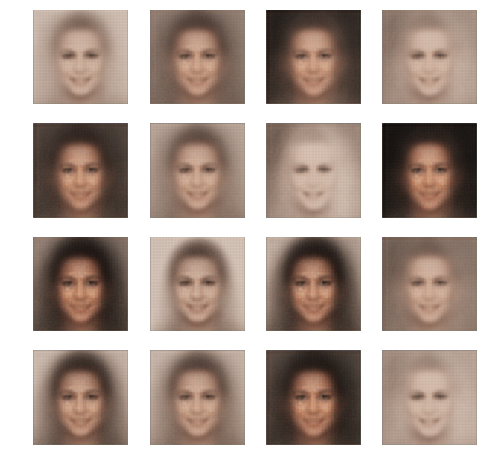

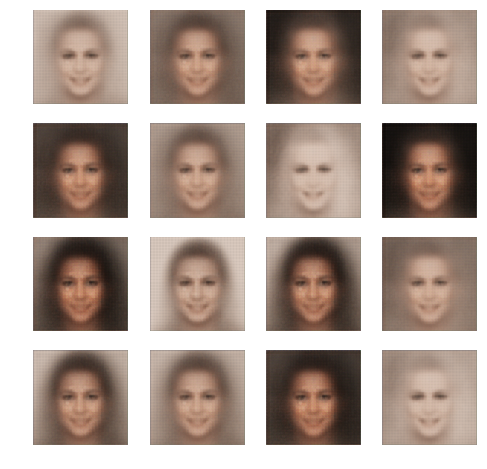

In [91]:
import time
from IPython import display

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)